# Advanced Optimization

In this tutorial we will show an example of "precise" QS optimization using a multigrid approach, and using constrained optimization

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

In [2]:
# from desc import set_device
# set_device("gpu")

In [3]:
import numpy as np

from desc.continuation import solve_continuation_automatic
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.geometry import FourierRZToroidalSurface
from desc.grid import LinearGrid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixPressure,
    FixPsi,
    ForceBalance,
    ObjectiveFunction,
    QuasisymmetryTwoTerm,
)
from desc.optimize import Optimizer

2024-08-14 17:59:57.506327: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


DESC version 0.12.1+143.gd5087d9c5.dirty,using JAX backend, jax version=0.4.31, jaxlib version=0.4.31, dtype=float64
Using device: NVIDIA A100 80GB PCIe (id=0), with 80.00 GB available memory


## Initial Guess

We start by creating an initial equilibrium and solving a standard fixed boundary problem:

In [4]:
# create initial surface. Aspect ratio ~ 8, circular cross section with slight
# axis torsion to make it nonplanar
surf = FourierRZToroidalSurface(
    R_lmn=[1, 0.125, 0.1],
    Z_lmn=[-0.125, -0.1],
    modes_R=[[0, 0], [1, 0], [0, 1]],
    modes_Z=[[-1, 0], [0, -1]],
    NFP=4,
)
# create initial equilibrium. Psi chosen to give B ~ 1 T. Could also give profiles here,
# default is zero pressure and zero current
eq = Equilibrium(M=4, N=4, Psi=0.04, surface=surf)
# this is usually all you need to solve a fixed boundary equilibrium
eq0 = solve_continuation_automatic(eq, verbose=0)[-1]

# it will be helpful to store intermediate results
eqfam = EquilibriaFamily(eq0)

## Multigrid method with proximal optimizer

By "multigrid" method we mean we will start by optimizing over boundary modes with $|m|, |n| \leq 1$, then $|m|, |n| \leq 2$ and so on. To do this we'll define a helper function that will create the necessary constraints and objectives for a given maximum mode number $k$.

By a "proximal" optimizer we mean one that handles the equilibrium constraint by re-solving a fixed boundary equilibrium problem at each step, given the current position of the boundary. This is made more efficient by using a perturbed estimate based on the previous step as a warm start to the equilibrium sub-problem.

In [5]:
def run_qh_step(k, eq):
    """Run a step of the precise QH optimization example from Landreman & Paul."""
    # this step will only optimize boundary modes with |m|,|n| <= k

    # create grid where we want to minimize QS error. Here we do it on 3 surfaces
    grid = LinearGrid(
        M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=np.array([0.6, 0.8, 1.0]), sym=True
    )

    # we create an ObjectiveFunction, in this case made up of multiple objectives
    # which will be combined in a least squares sense
    objective = ObjectiveFunction(
        (
            # pass in the grid we defined, and don't forget the target helicity!
            QuasisymmetryTwoTerm(eq=eq, helicity=(1, eq.NFP), grid=grid),
            # try to keep the aspect ratio about the same
            AspectRatio(eq=eq, target=8, weight=100),
        ),
    )
    # as opposed to SIMSOPT and STELLOPT where variables are assumed fixed, in DESC
    # we assume variables are free. Here we decide which ones to fix, starting with
    # the major radius (R mode = [0,0,0]) and all modes with m,n > k
    R_modes = np.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[
                np.max(np.abs(eq.surface.R_basis.modes), 1) > k, :
            ],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[
        np.max(np.abs(eq.surface.Z_basis.modes), 1) > k, :
    ]
    # next we create the constraints, using the mode number arrays just created
    # if we didn't pass those in, it would fix all the modes (like for the profiles)
    constraints = (
        ForceBalance(eq=eq),
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        FixPressure(eq=eq),
        FixCurrent(eq=eq),
        FixPsi(eq=eq),
    )
    # this is the default optimizer, which re-solves the equilibrium at each step
    optimizer = Optimizer("proximal-lsq-exact")

    eq_new, history = eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=20,  # we don't need to solve to optimality at each multigrid step
        verbose=3,
        copy=True,  # don't modify original, return a new optimized copy
        options={
            # Sometimes the default initial trust radius is too big, allowing the
            # optimizer to take too large a step in a bad direction. If this happens,
            # we can manually specify a smaller starting radius. Each optimizer has a
            # number of different options that can be used to tune the performance.
            # See the documentation for more info.
            "initial_trust_ratio": 1.0,
        },
    )

    return eq_new

Lets look at the initial field:

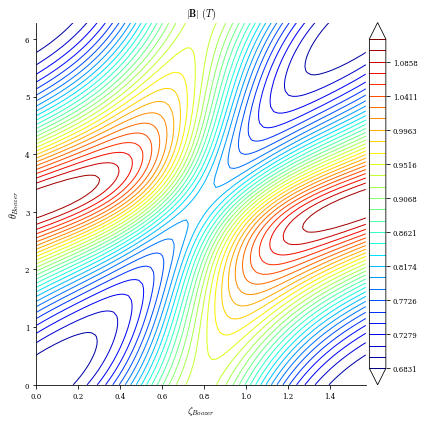

In [6]:
from desc.plotting import plot_boozer_surface

plot_boozer_surface(eq0);

We see that it is vaguely QH like, which is why we're targeting QH symmetry. Now let's run the optimization in steps and look at the intermediate result after each step: 

Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 600 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 25.4 ms
Timer: Objective build = 827 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 58.3 ms
Timer: Objective build = 203 ms
Timer: Proximal projection build = 5.21 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 919 ms
Timer: Linear constraint projection build = 1.35 sec
Number of parameters: 8
Number of objectives: 460
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          9.402e+01                                    4.166e+03   
       1              4          9.113e+01      2.890e+00      3.899e-02      1.89

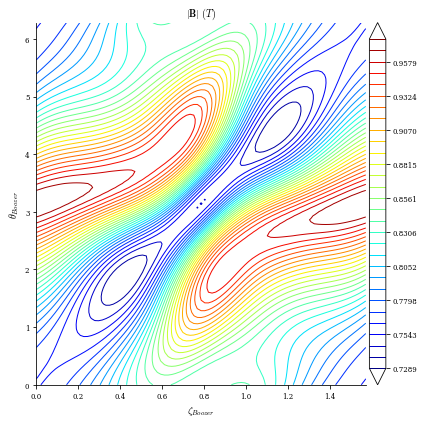

In [7]:
eq1 = run_qh_step(1, eq0)
eqfam.append(eq1)
plot_boozer_surface(eq1);

Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 53.9 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 25.2 ms
Timer: Objective build = 230 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 58.4 ms
Timer: Objective build = 199 ms
Timer: Proximal projection build = 2.96 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 948 ms
Timer: Linear constraint projection build = 1.16 sec
Number of parameters: 24
Number of objectives: 460
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          3.569e+01                                    1.509e+03   
       1              5          3.153e+01      4.160e+00      1.565e-02      2.

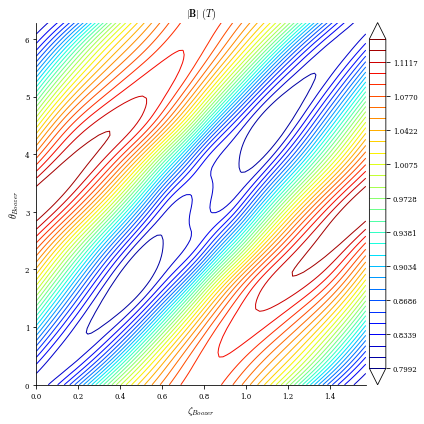

In [8]:
eq2 = run_qh_step(2, eq1)
eqfam.append(eq2)
plot_boozer_surface(eq2);

Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 55.0 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 25.3 ms
Timer: Objective build = 231 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 58.5 ms
Timer: Objective build = 201 ms
Timer: Proximal projection build = 2.28 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 851 ms
Timer: Linear constraint projection build = 1.91 sec
Number of parameters: 48
Number of objectives: 460
Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.213e-01                                    9.167e+01   
       1              4          1.674e-01      5.398e-02      6.905e-03      8.

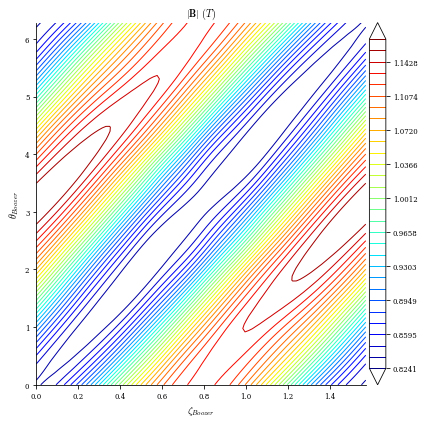

In [9]:
eq3 = run_qh_step(3, eq2)
eqfam.append(eq3)
plot_boozer_surface(eq3);

We see that after only 3 multigrid steps we have achieved very straight contours of magnetic field strength. These could be further refined by running for more iterations, using higher resolution, tighter tolerances, etc.

As a final comparison, we'll look at the maximum symmetry breaking boozer harmonic for each step of the equilibrium

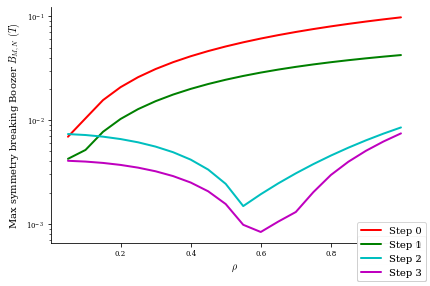

In [10]:
import matplotlib.pyplot as plt
from desc.plotting import plot_boozer_modes, plot_boundaries

fig, ax = plt.subplots()
colors = ["r", "g", "c", "m"]

for i, (eq, color) in enumerate(zip(eqfam, colors)):
    plot_boozer_modes(
        eq, color=color, helicity=(1, eq.NFP), max_only=True, label=f"Step {i}", ax=ax
    )

## Constrained Optimization

Next, we'll do a similar optimization but this time treating it as a constrained optimization problem, where we attempt to minimize QS error subject to more complicated constraints. We'll start with the same QS objective:

In [11]:
# create grid where we want to minimize QS error. Here we do it on 3 surfaces
grid = LinearGrid(
    M=eq0.M_grid, N=eq0.N_grid, NFP=eq0.NFP, rho=np.array([0.6, 0.8, 1.0]), sym=True
)

objective = ObjectiveFunction(
    (
        # pass in the grid we defined, and don't forget the target helicity!
        QuasisymmetryTwoTerm(eq=eq0, helicity=(1, eq.NFP), grid=grid),
    ),
)

For constraints, we'll include the standard force balance to start. In the previous example, fixing certain boundary modes served as a form of regularization to prevent the solution from going into a bad local minimum. In this case however, instead of fixing a range of boundary modes we will only fix the $R_{00}$ mode, and include constraints on aspect ratio, volume, and elongation to keep the solution from going off in a bad direction.

Finally, we also include a constraint on the average rotational transform:

In [12]:
from desc.objectives import Elongation, RotationalTransform, Volume

constraints = (
    ForceBalance(eq=eq0),
    # try to keep the aspect ratio between 7 and 9
    AspectRatio(eq=eq0, bounds=(7, 9)),
    # similarly, try to keep it from getting too elongated
    Elongation(eq=eq0, bounds=(0, 3)),
    # Keep volume the same as the initial volume
    Volume(eq=eq0, target=eq0.compute("V")["V"]),
    # target for average iota
    RotationalTransform(eq=eq0, target=1.1, loss_function="mean"),
    # fix major radius
    FixBoundaryR(eq=eq0, modes=[0, 0, 0]),
    # fix vacuum profiles
    FixPressure(eq=eq0),
    FixCurrent(eq=eq0),
    FixPsi(eq=eq0),
)

Finally, we'll use an optimizer that can handle general nonlinear constraints (the `proximal-lsq-exact` optimizer can only handle equilibrium constraints such as `ForceBalance` and regular linear constraints like `Fix*`). In this case we use a least-squares augmented Lagrangian method.

In [13]:
optimizer = Optimizer("lsq-auglag")

eqa, history = eq0.optimize(
    objective=objective,
    constraints=constraints,
    optimizer=optimizer,
    # each iteration of the augmented Lagrangian optimizer is cheaper than a step of a
    # proximal optimizer, but it generally requires more iterations to converge
    maxiter=200,
    copy=True,
    verbose=3,
    options={},
)

Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 53.3 ms
Timer: Objective build = 198 ms
Building objective: lcfs R
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 640 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 57.5 ms
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 25.0 ms
Building objective: elongation
Precomputing transforms
Timer: Precomputing transforms = 24.4 ms
Building objective: volume
Precomputing transforms
Timer: Precomputing transforms = 24.8 ms
Building objective: rotational transform
Precomputing transforms
Timer: Precomputing transforms = 205 ms
Timer: Objective build = 725 ms


      109            211         1.565e-03      3.443e-05      4.997e-03      2.011e+01      6.733e-03      1.000e+01      0.000e+00   
      110            213         1.532e-03      3.323e-05      4.943e-03      2.119e+01      6.662e-03      1.000e+01      0.000e+00   
      111            215         1.501e-03      3.120e-05      4.929e-03      2.307e+01      6.599e-03      1.000e+01      0.000e+00   
      112            217         1.472e-03      2.897e-05      4.960e-03      2.564e+01      6.542e-03      1.000e+01      0.000e+00   
      113            219         1.443e-03      2.852e-05      5.025e-03      2.839e+01      6.488e-03      1.000e+01      0.000e+00   
      114            221         1.411e-03      3.270e-05      5.093e-03      3.059e+01      6.437e-03      1.000e+01      0.000e+00   
      115            223         1.369e-03      4.148e-05      5.125e-03      3.159e+01      6.384e-03      1.000e+01      0.000e+00   
      116            225         1.320e-03      

As before, results can be improved by running for more iterations. Note the constraint violation may be larger than desired, so it can be helpful to call `eq.solve()` at the end to decrease the force error without changing the boundary.

In [14]:
eqa.solve();

Building objective: force
Precomputing transforms
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Number of parameters: 120
Number of objectives: 850
Starting optimization
Using method: lsq-exact
Optimization terminated successfully.
`ftol` condition satisfied.
         Current function value: 3.112e-06
         Total delta_x: 7.051e-02
         Iterations: 3
         Function evaluations: 4
         Jacobian evaluations: 4
Start of solver   -->   End of solver
Total (sum of squares):  5.430e-05  -->   3.112e-06, 
Maximum absolute Force error:  2.243e+03   -->   5.160e+02(N)
Minimum absolute Force error:  1.218e-01   -->   4.213e-02(N)
Average abso

From the Boozer plot below we see that we are already doing fairly good for QS:

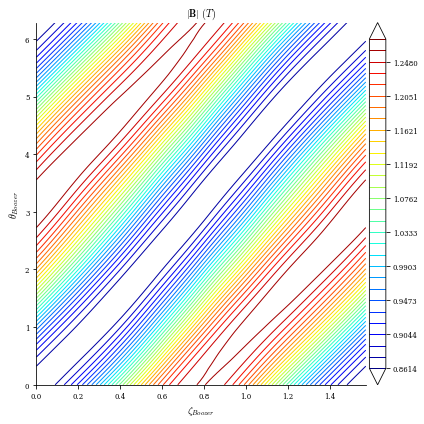

In [15]:
plot_boozer_surface(eqa);

As a final comparison, we can look at the boundary shapes obtained by the different methods. We see that the final shapes are fairly similar, with the proximal method giving slightly more elongation and tighter curvature. We could include additional objectives or constraints to try to reduce this if desired.

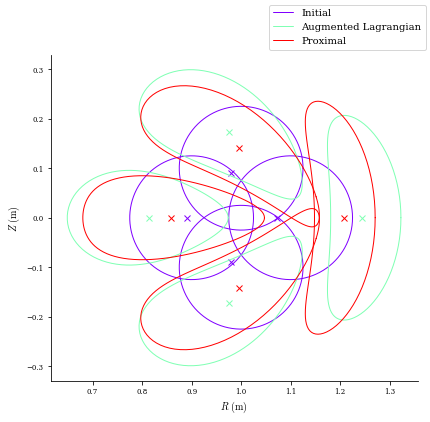

In [16]:
plot_boundaries(
    [eq0, eqa, eqfam[-1]], labels=["Initial", "Augmented Lagrangian", "Proximal"]
);

Further example scripts for precise QS optimization can be found in the `desc/examples` folder